# 1D Burgers Data-Driven Parameter Discovery PINN

*Last edited: 2024-04-19*  
*Created: 2023-11-30*

Based on: <https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)> .

Terms:

* **Discorery** is when the network is able to identify the underlying partial differential equation.

* **Continous time** models take into account the exact time interval between measurements.

In the train phase the neural network estimates a solution $u(t,x)$.
The function employed by the PINN, $f(t,x)$ (Equation 2), is derived from the known Burgers' equation, and allows to calculate the loss function.
The parameters of the differential operator that we want to obtain are transformed into PINN parameters.
In the following equations, the differential operator parameter $\lambda_1$ (or $u$) is the speed of fluid at the indicated spatial and temporal coordinates, the differential operator parameter $\lambda_2$ (or $\nu$) is the kinematic viscosity of fluid, and the subscripts denote partial differentiation in time and space, respectively, as
$u_t$ (which denotes $\frac{du}{dt}$), 
$u_x$ (which denotes $\frac{du}{dx}$), and 
$u_{xx}$ (which denotes $\frac{d^2u}{dx^2}$).

$$
u_t + \lambda_1 u_x - \lambda_2 u_{xx} = 0, \quad x \in [-1,1], \ t \in [0, 1]  \tag{1}
$$

The Burgers' equation is employed to evaluate the error $f$ of the solution $u(t,x)$ estimated by the PINN, as shown in Equation 2.

$$
f := u_t + \lambda_1 u_x - \lambda_2 u_{xx} \tag{2}
$$

## Hyperparameters and others

In [1]:
import numpy as np

In [2]:
nu = 0.01/np.pi

N_u = 2000

layers = [2, 20, 20, 20, 20, 1]

datafile = 'data/burgers_shock.mat'

## Libraries & Setup

In [3]:
%env TF_CPP_MIN_LOG_LEVEL=3
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import os

import scipy.io
data = scipy.io.loadmat(datafile)

import matplotlib.pyplot as plt
my_rc_param = {'text.usetex': False}
plt.rcParams.update(my_rc_param)

import logging
import tensorflow as tf
logging.disable(logging.WARNING)
logging.getLogger('tensorflow').disabled = True
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Prevent tensorflow from allocating all GPU memory
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

# For reproducibility
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

env: TF_CPP_MIN_LOG_LEVEL=3


OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141359 thread 0 bound to OS proc set 0


In [4]:
print(tf.__version__)

1.15.0


## Plotting module

In [5]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

def newfig(width, nplots=1):
    # fig = plt.figure(figsize=figsize(width, nplots)) #latex
    fig = plt.figure()
    ax = fig.add_subplot(111)
    return fig, ax

## PINN

L-BFGS-B parameters (<https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html>):
- *maxiter* - Maximum number of iterations.
- *maxfun* - maximum number of function evaluations. Note that this function may violate the limit because of evaluating gradients by numerical differentiation.
- *maxcor* - the maximum number of variable metric corrections used to define the limited memory matrix. (The limited memory BFGS method does not store the full hessian but uses this many terms in an approximation to it.)
- *ftol* - the iteration stops when $(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1}$ <= ftol.
- *maxls* - maximum number of line search steps (per iteration). Default is 20.

In [6]:
class PhysicsInformedNN:

    def __init__(self, X, u, layers, lb, ub):
        self.lb = lb
        self.ub = ub
        self.x = X[:, 0:1]
        self.t = X[:, 1:2]
        self.u = u
        self.layers = layers
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        self.loss = ( tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) +
            tf.reduce_mean(tf.square(self.f_pred)) )

        # L-BFGS-B optimizer
        # https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            self.loss,
            method='L-BFGS-B',
            options={
                'maxiter': 50000,
                'maxfun': 50000,
                'maxcor': 50,
                'maxls': 50,
                # The smallest representable number such that 1.0 + eps != 1.0
                'ftol': 1.0 * np.finfo(float).eps
            })

        # Adam optimizer
        #self.optimizer_Adam = tf.train.AdamOptimizer()
        #self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # TF startup
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev),
                           dtype=tf.float32)

    # structure definition
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32),
                            dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u
        
    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    # train definition
    # def callback(self, loss, lambda_1, lambda_2):
    #     print('Loss: %e, Lambda_1: %.5f, Lambda_2: %.5f'
    #           % (loss, lambda_1, np.exp(lambda_2)))
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        # print("=== start Adam optimizer ===")
        # for it in range(nIter):
        #     self.sess.run(self.train_op_Adam, tf_dict)
        #     if it % 100 == 0:
        #         loss_value = self.sess.run(self.loss, tf_dict)
        #         lambda_1_value = self.sess.run(self.lambda_1)
        #         lambda_2_value = np.exp(self.sess.run(self.lambda_2))
        #         print('Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f'
        #             % (loss_value, lambda_1_value, lambda_2_value))
                
        print("L-BFGS-B optimizer run.")
        self.optimizer.minimize(
            self.sess,
            feed_dict=tf_dict,
            # fetches=[self.loss, self.lambda_1, self.lambda_2],
            # loss_callback=self.callback
        )

    # prediction definition
    def predict(self, X_star):
        tf_dict = {self.x_tf: X_star[:, 0:1], self.t_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        return u_star, f_star

## Main

In [7]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

## Model

In [8]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localho

## Train

Computing-intensive part

In [9]:
%%time
model.train(0)

L-BFGS-B optimizer run.


OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141423 thread 1 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141440 thread 2 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141441 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141442 thread 4 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141424 thread 5 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141443 thread 6 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141445 thread 8 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 141359 tid 141444 thread 7 bound to OS proc set 3


CPU times: user 1min 9s, sys: 5.62 s, total: 1min 14s
Wall time: 55.8 s


## Predict

In [10]:
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

### Show the identified PDE

In [11]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [12]:
print(r'Correct PDE: u_t + u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE: u_t + u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99958 u u_x - 0.0032199 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [13]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 3.885382e-03
Error l1: 0.04194%
Error l2: 1.15602%


## Plotting

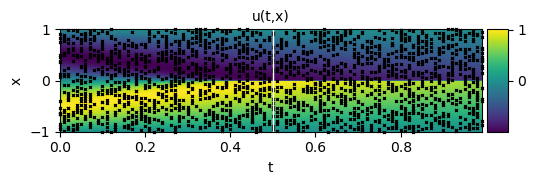

In [43]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

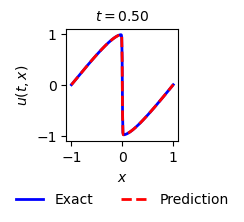

In [44]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()